# GridStatus <-> LBNL Status Mapping

GridStatus reads raw ISO queues. The LBNL queue statuses are standardized versions of ISO-specific categories. This notebook attempts to reverse engineer the mappings between the two.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

from dbcp.extract.lbnl_iso_queue import extract


/app/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/app/.local/lib/python3.10/site-packages/pudl/analysis/spatial.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

## Get the data
### LBNL-Compiled Queues

In [2]:
# partial implementation of transform. I don't want to include deduplication.
def partial_transform(active_projects: pd.DataFrame) -> pd.DataFrame:
    """Transform active iso queue data."""
    rename_dict = {
        "state": "raw_state_name",
        "county": "raw_county_name",
    }
    active_projects = active_projects.rename(columns=rename_dict)  # copy
    # Harmonize the interconnection_status_lbnl values.
    mapping = {
        "Feasability Study": "Feasibility Study",
        "Feasibility": "Feasibility Study",
        "Facilities Study": "Facility Study",
        "IA in Progress": "In Progress (unknown study)",
        "Unknown": "In Progress (unknown study)",
        "Withdrawn, Feasibility Study": "Withdrawn",
    }
    active_projects.loc[:, "interconnection_status_lbnl"] = active_projects.loc[
        :, "interconnection_status_lbnl"
    ].replace(mapping)
    # drop irrelevant columns (structurally all nan due to 'active' filter)
    active_projects.drop(columns=["date_withdrawn", "date_operational"], inplace=True)
    return active_projects


source_path = Path("/app/data/raw/queues_2022_clean_data.xlsx")
raw_lbnl = extract(source_path)["lbnl_iso_queue"]
lbnl = partial_transform(raw_lbnl)


In [3]:
lbnl.shape, lbnl.columns


((29033, 27),
 Index(['queue_id', 'queue_status', 'queue_date', 'queue_year', 'interconnection_date', 'entity', 'project_name', 'developer', 'utility', 'county_1', 'county_2', 'county_3', 'raw_state_name', 'region', 'interconnection_service_type', 'point_of_interconnection', 'date_proposed', 'year_proposed', 'interconnection_status_raw', 'interconnection_status_lbnl', 'resource_type_lbnl', 'resource_type_1', 'resource_type_2', 'resource_type_3', 'capacity_mw_resource_1', 'capacity_mw_resource_2', 'capacity_mw_resource_3'], dtype='object'))

In [4]:
lbnl.head(2)


,queue_id,queue_status,queue_date,queue_year,interconnection_date,entity,project_name,developer,utility,county_1,county_2,county_3,raw_state_name,region,interconnection_service_type,point_of_interconnection,date_proposed,year_proposed,interconnection_status_raw,interconnection_status_lbnl,resource_type_lbnl,resource_type_1,resource_type_2,resource_type_3,capacity_mw_resource_1,capacity_mw_resource_2,capacity_mw_resource_3
0,GIA-97,withdrawn,1/7/2022,2022.0,NaN,AEC,NaN,NaN,AEC,new madrid,NaN,NaN,MO,Southeast (non-ISO),Network,New Madrid - Essex 345kV,10/31/2024,2024.0,Withdrawn,Withdrawn,Solar,Solar,NaN,NaN,350.0,NaN,NaN
1,GIA-40,active,10/24/2009,2009.0,NaN,AEC,NaN,NaN,AEC,new madrid,NaN,NaN,MO,Southeast (non-ISO),Network Resource,NM Switchyard (345 kV Bus),11/1/2011,2011.0,Upgrade Approved,IA Executed,Coal,Coal,NaN,NaN,20.0,NaN,NaN


### GridStatus Queues

In [12]:
import dbcp

# These are the revision numbers of the oldest archives we have
iso_queue_versions: dict[str, str] = {
    "miso": "1681775160487863",
    "caiso": "1681775162586588",
    "pjm": "1681775160979859",
    "ercot": "1681775161342766",
    "spp": "1681775162935809",
    "nyiso": "1681775159356063",
    "isone": "1681775162111351",
}

gs_dfs = dbcp.extract.gridstatus_isoqueues.extract(iso_queue_versions)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-ka1m0ue4fptfmt9siejdd5lom7p39upa.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fpydata-google-auth.readthedocs.io%2Fen%2Flatest%2Foauth.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=kMUNP02mhP8Ixt4f2otfoYP8bYPJxh&access_type=offline


KeyboardInterrupt: Interrupted by user

In [13]:
{k: v.shape for k, v in gs_dfs.items()}

{'miso': (4253, 31),
 'caiso': (2278, 36),
 'pjm': (9030, 37),
 'ercot': (1203, 35),
 'spp': (950, 24),
 'nyiso': (1535, 24),
 'isone': (1533, 31)}

In [14]:
# # These are manually downloaded from our archives. I went back as far as I could,
# # which is April 17 2023.
# # There is a 3.5 month gap between the LBNL queues and our oldest GridStatus archive.
# root_path = Path("/app/data/raw/gridstatus/interconnection_queues")
# assert root_path.exists()
# # filenames are like "interconnection_queues_caiso_4-17-2023.parquet"
# gs_dfs = {
#     path.name.split("_")[2]: pd.read_parquet(path)
#     for path in root_path.glob("*.parquet")
# }
# {k: v.shape for k, v in gs_dfs.items()}


In [15]:
# wayyy fewer items in GridStatus than LBNL.
sum([v.shape[0] for v in gs_dfs.values()]) - lbnl.shape[0]


-8251

In [16]:
lbnl.region.value_counts()

PJM                    7738
West (non-ISO)         6610
MISO                   4071
Southeast (non-ISO)    3070
CAISO                  2274
ERCOT                  1952
NYISO                  1260
ISO-NE                 1255
SPP                     802
Name: region, dtype: int64

In [17]:
lbnl_iso = lbnl[~lbnl["region"].str.contains("non-ISO", na=False)].copy()

In [18]:
sum([v.shape[0] for v in gs_dfs.values()]) - lbnl_iso.shape[0]

1429

Gridstatus has more ISO projects

In [19]:
# globals().update(gs_dfs)  # this works fine but the static type checker/linter can't introspect it.
raw_ercot = gs_dfs["ercot"]
raw_nyiso = gs_dfs["nyiso"]
raw_isone = gs_dfs["isone"]
raw_miso = gs_dfs["miso"]
raw_pjm = gs_dfs["pjm"]
raw_spp = gs_dfs["spp"]
raw_caiso = gs_dfs["caiso"]


In [20]:
LBNL_JOIN_COLS = [
    "queue_id",  # join key
    "project_name",  # for manually checking the joins
    "queue_date",  # for manually checking the joins
    "queue_status",  # for manually checking the joins
    "interconnection_status_raw",  # see what LBNL interpreted
    "interconnection_status_lbnl",  # final mapping value
    "capacity_mw_resource_1",
    "resource_type_1"
    
]


def join_lbnl(
    iso_df: pd.DataFrame, lbnl: pd.DataFrame, iso_name: str, iso_id_col="Queue ID"
) -> pd.DataFrame:
    """Join LBNL queue data to GridStatus queue data."""
    assert iso_df[iso_id_col].is_unique, "ID column not unique"
    lbnl_iso = lbnl.loc[lbnl["entity"].eq(iso_name), LBNL_JOIN_COLS]
    assert not lbnl_iso.empty, f"Empty LBNL queue for {iso_name}"
    assert lbnl_iso["queue_id"].is_unique, "LBNL queue ID not unique"
    out = iso_df.merge(lbnl_iso, how="outer", left_on=iso_id_col, right_on="queue_id")
    out["in_lbnl"] = ~out["queue_id"].isna()
    out["in_gs"] = ~out[iso_id_col].isna()
    return out


## Comparisons
### ERCOT
* ERCOT's queue document has separate excel sheets for large and small (< 20MW) projects, and does not list withdrawn projects. GridStatus only includes large projects, whereas LBNL data includes the other categories. I'm not sure where LBNL gets the withdrawn projects from.
  * We might be able to maintain a withdrawn list by 1) getting all the current withdrawn projects from the LBNL data, then 2) loading all the archived GridStatus ERCOT queues and checking for any projects that enter then exit the list. But I don't think we actually need a withdrawn list?
* GridStatus defines "status" as "IA Signed".isna(). LBNL calls the entire "large active" dataset "active".

In [243]:
raw_ercot.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'Fuel', 'Technology', 'GIM Study Phase', 'Screening Study Started', 'Screening Study Complete', 'FIS Requested', 'FIS Approved', 'Economic Study Required', 'IA Signed', 'Air Permit', 'GHG Permit', 'Water Availability', 'Meets Planning', 'Meets All Planning', 'CDR Reporting Zone', 'Approved for Energization', 'Approved for Synchronization', 'Comment'], dtype='object')

In [244]:
ercot = join_lbnl(raw_ercot, lbnl, "ERCOT")
ercot.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2273 entries, 0 to 2272
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Queue ID                      1203 non-null   object        
 1   Project Name                  1203 non-null   object        
 2   Interconnecting Entity        1203 non-null   object        
 3   County                        1203 non-null   object        
 4   State                         1203 non-null   object        
 5   Interconnection Location      1203 non-null   object        
 6   Transmission Owner            0 non-null      object        
 7   Generation Type               1203 non-null   object        
 8   Capacity (MW)                 1203 non-null   float64       
 9   Summer Capacity (MW)          0 non-null      object        
 10  Winter Capacity (MW)          0 non-null      object        
 11  Queue Date                    

In [245]:
ercot[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
False  True       1070
True   True        882
       False       321
dtype: int64

#### Compare total capacity for projects in both

In [246]:
both_ercot = ercot[ercot.in_lbnl & ercot.in_gs]

compare_capacity(both_ercot)

GS Capacity for projects in GS and LBNL: 182416.3
LBNL Capacity for project in GS and LBNL: 180467.1
Ratio of LBNL to GS Capacity for project in GS and LBNL: 0.9893145513860331


#### Compare total capacity for **active** projects in both

In [248]:
ercot[["Status", "queue_status"]].value_counts(dropna=False)

Status     queue_status
NaN        withdrawn       736
Active     active          599
NaN        operational     313
Active     NaN             284
Completed  active          282
           NaN              37
NaN        active           21
Completed  operational       1
dtype: int64

In [250]:
ercot_active_in_both = ercot[ercot["queue_status"].eq("active") & ercot["Status"].eq("Active")]
compare_capacity(ercot_active_in_both)

GS Capacity for projects in GS and LBNL: 125563.82
LBNL Capacity for project in GS and LBNL: 125430.0
Ratio of LBNL to GS Capacity for project in GS and LBNL: 0.9989342471422101


Very little mismatching in status columns and capacities look good for projects that are active in both. There a few dozen lbnl active projects that are withdrawn or completed in GS.

#### Compare total capacity for all projects

In [251]:
gs_capacities = ercot[ercot.in_gs]["Capacity (MW)"]
lbnl_capacities = ercot[ercot.in_lbnl]["capacity_mw_resource_1"]

print(f"Ratio of total LBNL capacity to total GS capacity {lbnl_capacities.sum() / gs_capacities.sum()}")
print(f"Ratio of total LBNL project to total GS projects {len(lbnl_capacities) / len(gs_capacities)}")

Ratio of total LBNL capacity to total GS capacity 1.8563902566295587
Ratio of total LBNL project to total GS projects 1.622610141313383


Where is LBNL getting historic queue data from?

In [253]:
ercot["queue_status"].value_counts()

active         902
withdrawn      736
operational    314
Name: queue_status, dtype: int64

<AxesSubplot: ylabel='Frequency'>

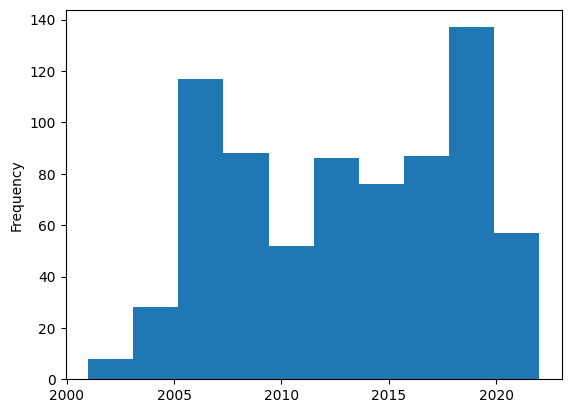

In [259]:
pd.to_datetime(ercot[ercot["queue_status"].eq("withdrawn")]["queue_date"]).dt.year.plot.hist()

The [ISO Queue sheet](https://www.ercot.com/misdownload/servlets/mirDownload?doclookupId=955158734') Grid Status uses has an Inactive sheet that only goes back to about 2019. 

### NYISO

* LBNL appears to have used the column labeled `S`, which is an ordinal status number corresponding to NYISO's LFIP. Key:
  * 0=Withdrawn
  * 1=Scoping Meeting Pending
  * 2=FES Pending
  * 3=FES in Progress
  * 4=SRIS/SIS Pending
  * 5=SRIS/SIS in Progress
  * 6=SRIS/SIS Approved
  * 7=FS Pending
  * 8=Rejected Cost Allocation/Next FS Pending
  * 9=FS in Progress
  * 10=Accepted Cost Allocation/IA in Progress
  * 11=IA Completed
  * 12=Under Construction
  * 13=In Service for Test
  * 14=In Service Commercial
  * 15=Partial In-Service
* Availability of Studies  Key: None=Not Available, FES=Feasibility Study Available, SRIS=System Reliability Impact Study Available, FS=Facilities Study and/or ATRA Available
* CY Completion/SGIA Tender refers to the Attachment X milestone used to apply the 4-year COD limitation.


In [21]:
raw_nyiso.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'Proposed  In-Service', 'Proposed Initial-Sync Date', 'Last Updated Date', 'Z', 'S', 'Availability of Studies', 'SGIA Tender Date'], dtype='object')

In [22]:
raw_nyiso[raw_nyiso["Queue ID"].duplicated(keep=False)]

,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Proposed In-Service,Proposed Initial-Sync Date,Last Updated Date,Z,S,Availability of Studies,SGIA Tender Date
5,0430,Cedar Rapids Transmission,None,St. Lawrence,NY,None,NM-NG,AC Transmission,0.0,<NA>,<NA>,2014-03-05,Active,NaT,<NA>,None,<NA>,NaT,NaT,12/31/2019,D,12.0,"SIS, FS",None
626,0127A,Munnsville,"Airtricity Munnsville Wind Farm, LLC",Madison,NY,46kV line,NYSEG,Wind,6.0,6,<NA>,2002-10-09,Withdrawn,NaT,2014-01-31 00:00:00,None,<NA>,NaT,NaT,<NA>,E,0,None,None
1442,0127A,Munnsville,None,Madison,NY,None,NYSEG,Wind,40.0,40.0,<NA>,2002-10-09,Completed,NaT,<NA>,None,3/31/13,NaT,NaT,3/31/13,E,"11,14","SRIS, CY06",None
1517,0430,Cedar Rapids Transmission,None,St. Lawrence,NY,None,NM-NG,AC Transmission,0.0,<NA>,<NA>,2014-03-05,Completed,NaT,<NA>,None,2022-03-31 00:00:00,NaT,2021-10-01,2022-03-31 00:00:00,D,14,"SIS, FS",None


In [23]:
# I don't know which is correct (if either), but I'll guess that the later one is. So keep='last'
raw_nyiso.loc[raw_nyiso.duplicated(subset='Queue ID', keep=False), :].sort_values(by='Queue ID')


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Proposed In-Service,Proposed Initial-Sync Date,Last Updated Date,Z,S,Availability of Studies,SGIA Tender Date
626,0127A,Munnsville,"Airtricity Munnsville Wind Farm, LLC",Madison,NY,46kV line,NYSEG,Wind,6.0,6,<NA>,2002-10-09,Withdrawn,NaT,2014-01-31 00:00:00,None,<NA>,NaT,NaT,<NA>,E,0,None,None
1442,0127A,Munnsville,None,Madison,NY,None,NYSEG,Wind,40.0,40.0,<NA>,2002-10-09,Completed,NaT,<NA>,None,3/31/13,NaT,NaT,3/31/13,E,"11,14","SRIS, CY06",None
5,0430,Cedar Rapids Transmission,None,St. Lawrence,NY,None,NM-NG,AC Transmission,0.0,<NA>,<NA>,2014-03-05,Active,NaT,<NA>,None,<NA>,NaT,NaT,12/31/2019,D,12.0,"SIS, FS",None
1517,0430,Cedar Rapids Transmission,None,St. Lawrence,NY,None,NM-NG,AC Transmission,0.0,<NA>,<NA>,2014-03-05,Completed,NaT,<NA>,None,2022-03-31 00:00:00,NaT,2021-10-01,2022-03-31 00:00:00,D,14,"SIS, FS",None


In [24]:
nyiso = join_lbnl(raw_nyiso.drop_duplicates(subset='Queue ID', keep='last'), lbnl, "NYISO")
nyiso.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1607 entries, 0 to 1606
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Queue ID                     1533 non-null   object        
 1   Project Name                 1533 non-null   object        
 2   Interconnecting Entity       887 non-null    object        
 3   County                       1450 non-null   object        
 4   State                        1451 non-null   object        
 5   Interconnection Location     877 non-null    object        
 6   Transmission Owner           1527 non-null   object        
 7   Generation Type              1392 non-null   object        
 8   Capacity (MW)                1533 non-null   float64       
 9   Summer Capacity (MW)         1433 non-null   string        
 10  Winter Capacity (MW)         1280 non-null   string        
 11  Queue Date                   1533 non-null 

In [25]:
nyiso.head()


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Proposed In-Service,Proposed Initial-Sync Date,Last Updated Date,Z,S,Availability of Studies,SGIA Tender Date,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,capacity_mw_resource_1,resource_type_1,in_lbnl,in_gs
0,0276,Homer Solar Energy Center,None,Cortland,NY,None,NM-NG,Solar,90.0,90.0,90.0,2008-01-30,Active,2023-09-01,<NA>,None,<NA>,NaT,2023-09-01,9/30/2022,C,10.0,"FES, SRIS, FS",None,0276,Homer Solar Energy Center,1/30/2008,active,"FES, SRIS, FS",Facility Study,90.0,Solar,True,True
1,0396,Baron Winds,None,Steuben,NY,None,NYSEG,Wind,235.0,235.0,235.0,2012-11-30,Active,2023-12-01,<NA>,None,<NA>,NaT,NaT,12/31/2022,C,15.0,"FES, SRIS, FS",None,0396,Baron Winds,11/30/2012,active,"FES, SRIS, FS",Facility Study,238.0,Wind,True,True
2,0396A,Wood Street Transformer,None,Putnam,NY,None,NYSEG,AC Transmission,0.0,<NA>,<NA>,2012-12-14,Active,NaT,<NA>,None,<NA>,NaT,NaT,4/30/2021,G,12.0,SIS,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
3,0422,Eight Point Wind Energy Center,None,Steuben-Allegany,NY,None,NYSEG,Wind,101.8,101.8,101.8,2013-11-07,Active,NaT,<NA>,None,<NA>,NaT,NaT,3/31/2021,C,14.0,"FES, SRIS, FS",None,0422,Eight Point Wind Energy Center,11/7/2013,active,"FES, SRIS, FS",Facility Study,102.0,Wind,True,True
4,0429,North Rockland Station,None,Steuben,NY,None,ConEd,AC Transmission,0.0,<NA>,<NA>,2014-02-12,Active,NaT,<NA>,None,<NA>,NaT,NaT,3/31/2022,G,12.0,SIS,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


In [26]:
nyiso[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1186
       False       347
False  True         74
dtype: int64

In [27]:
# marginal improvement from date filter
nyiso.loc[
    nyiso["Queue Date"]
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1186
       False       324
False  True         74
dtype: int64

### NYISO Capacity Comparison
- Compare total capacity for projects in lbnl and gs
- Compare total capacity for active projects in lbnl and gs
- Compare total capacity for active projects
- Compare capacity by fuel type? Might challenging because the categories are all over the place

#### Compare total capacity for projects in both

In [142]:
def compare_capacity(comb_iso: pd.DataFrame, gs_cap_col="Capacity (MW)", lbnl_cap_col="capacity_mw_resource_1"):    
    gs_iso_cap = comb_iso[gs_cap_col].sum()
    lbnl_iso_cap = comb_iso[lbnl_cap_col].sum()

    print(f"GS Capacity for projects in GS and LBNL: {gs_iso_cap}")
    print(f"LBNL Capacity for project in GS and LBNL: {lbnl_iso_cap}")
    print(f"Ratio of LBNL to GS Capacity for project in GS and LBNL: {lbnl_iso_cap / gs_iso_cap}")
    
    

In [65]:
both_nyiso = nyiso[nyiso.in_lbnl & nyiso.in_gs]

compare_capacity(both_nyiso)

GS Capacity for projects in GS and LBNL: 226128.46
LBNL Capacity for project in GS and LBNL: 228118.59999999998
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.008800926694499


Ok! Projects that exist in both have very similar total capacities! That's a good start. I could look into which projects have different capacity values but the amount is so minor that I'm going to skip for now.

#### Compare total capacity for **active** projects in both

In [66]:
both_nyiso["queue_status"].value_counts()

withdrawn      713
active         459
operational     14
Name: queue_status, dtype: int64

In [67]:
both_nyiso[["Status", "queue_status"]].value_counts(dropna=False)

Status     queue_status
Withdrawn  withdrawn       712
Active     active          421
Withdrawn  active           38
Completed  operational      14
           withdrawn         1
dtype: int64

There are some active LBNL projects that have been withdrawn maybe because the GS data is a bit fresher? If so the withdrawl dates should be after 2022-12-31.

In [68]:
pd.to_datetime(both_nyiso[(both_nyiso["Status"] == "Withdrawn") & (both_nyiso["queue_status"] == "active")]["Withdrawn Date"]).dt.year.value_counts()

2023    38
Name: Withdrawn Date, dtype: int64

Great! That explains it. This means we can just compare projects marked active in lbnl

In [69]:
active_both_nyiso = both_nyiso[(both_nyiso["queue_status"] == "active")]
gs_nyiso_cap = active_both_nyiso["Capacity (MW)"].sum()
lbnl_nyiso_cap = active_both_nyiso["capacity_mw_resource_1"].sum()

print(gs_nyiso_cap)
print(lbnl_nyiso_cap)
print(lbnl_nyiso_cap / gs_nyiso_cap)

108584.66
110592.0
1.0184864049857503


Similar capacity totals I'm comfortable with.

#### Compare total capacity for all projects

In [70]:
nyiso[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1186
       False       347
False  True         74
dtype: int64

In [71]:
nyiso[["Status", "queue_status"]].value_counts(dropna=False)

Status     queue_status
Withdrawn  withdrawn       712
Active     active          421
Withdrawn  NaN             137
Completed  NaN             106
Active     NaN             104
NaN        operational      74
Withdrawn  active           38
Completed  operational      14
           withdrawn         1
dtype: int64

In [72]:
print(nyiso[nyiso.in_gs & ~nyiso.in_lbnl]["Capacity (MW)"].sum() / nyiso[nyiso.in_gs]["Capacity (MW)"].sum())
print(nyiso[~nyiso.in_gs & nyiso.in_lbnl]["capacity_mw_resource_1"].sum() / nyiso[nyiso.in_lbnl]["Capacity (MW)"].sum())

0.2705746493529786
0.04379634478561434


Projects in GS but not in lbnl account for 27% of total capacity in GS nyiso.
Projects in LBNL but not in GS account for 4% of total capacity in LBNL NYISO.

Why does GS have so much more capacity than LBNL here? Do we care if GS has more capacity than LBNL given GS more closely resembles the source data? Is LBNL doing deduplication work behind the scenes?

In [241]:
gs_capacities = nyiso[nyiso.in_gs]["Winter Capacity (MW)"]
lbnl_capacities = nyiso[nyiso.in_lbnl]["capacity_mw_resource_1"]

print(f"Ratio of total LBNL capacity to total GS capacity {lbnl_capacities.sum() / pd.to_numeric(gs_capacities, errors='coerce').sum()}")
print(f"Ratio of total LBNL project to total GS projects {len(lbnl_capacities) / len(gs_capacities)}")

Ratio of total LBNL capacity to total GS capacity 0.9233459635021418
Ratio of total LBNL project to total GS projects 0.821917808219178


There are 190 transmission projects in GS that aren't in LBNL. See generation type analysis notebook.

### MISO
Very good project coverage, but the IA status categories are a mess.

In [73]:
raw_miso.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'facilityType', 'Post Generator Interconnection Agreement Status', 'Interconnection Approval Date', 'inService', 'giaToExec', 'studyCycle', 'studyGroup', 'studyPhase', 'svcType', 'dp1ErisMw', 'dp1NrisMw', 'dp2ErisMw', 'dp2NrisMw', 'sisPhase1'], dtype='object')

In [74]:
# I don't know which is correct (if either), but I'll guess that the later one is. So keep='last'
# Nearly whole-row duplicate, except for "studyPhase"
raw_miso.loc[raw_miso.duplicated(subset='Queue ID', keep=False), :].sort_values(by='Queue ID')


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,facilityType,Post Generator Interconnection Agreement Status,Interconnection Approval Date,inService,giaToExec,studyCycle,studyGroup,studyPhase,svcType,dp1ErisMw,dp1NrisMw,dp2ErisMw,dp2NrisMw,sisPhase1
2213,J392,None,None,Otsego County,MI,ITC/METC 138 kV Livingston to Stover line,"Michigan Electric Transmission Company, LLC",Gas,420.7,383.1,420.7,2014-09-15T04:00:00Z,Done,2015-09-01T04:00:00Z,None,None,None,CT Combustion Turbine (Simple Cycle),In Service,2016-03-23T04:00:00Z,2016-05-16T04:00:00Z,2016-03-23T04:00:00Z,DPP-2015-FEB,East (ITC),Network Upgrade,NRIS,0.0,0.0,0.0,0.0,
2214,J392,None,None,Otsego County,MI,ITC/METC 138 kV Livingston to Stover line,"Michigan Electric Transmission Company, LLC",Gas,420.7,383.1,420.7,2014-09-15T04:00:00Z,Done,2015-09-01T04:00:00Z,None,None,None,CT Combustion Turbine (Simple Cycle),In Service,2016-03-23T04:00:00Z,2016-05-16T04:00:00Z,2016-03-23T04:00:00Z,DPP-2015-FEB,East (ITC),Int FaS,NRIS,0.0,0.0,0.0,0.0,


In [75]:
# I don't know which is correct (if either), but I'll guess that the later one is. So keep='last'
# Nearly whole-row duplicate, except for "studyPhase"
lbnl.query('entity == "MISO"').loc[lbnl.query('entity == "MISO"').duplicated(subset='queue_id', keep=False), :].sort_values(by='queue_id')


,queue_id,queue_status,queue_date,queue_year,interconnection_date,entity,project_name,developer,utility,county_1,county_2,county_3,raw_state_name,region,interconnection_service_type,point_of_interconnection,date_proposed,year_proposed,interconnection_status_raw,interconnection_status_lbnl,resource_type_lbnl,resource_type_1,resource_type_2,resource_type_3,capacity_mw_resource_1,capacity_mw_resource_2,capacity_mw_resource_3
10519,J392,operational,9/15/2014,2014.0,3/23/2016,MISO,NaN,NaN,"Michigan Electric Transmission Company, LLC",otsego,NaN,NaN,MI,MISO,NRIS,ITC/METC 138 kV Livingston to Stover line,5/16/2016,2016.0,In Service,Operational,Gas,Gas,NaN,NaN,421.0,NaN,NaN
10842,J392,operational,9/15/2014,2014.0,3/23/2016,MISO,NaN,NaN,"Michigan Electric Transmission Company, LLC",otsego,NaN,NaN,MI,MISO,NRIS,ITC/METC 138 kV Livingston to Stover line,5/16/2016,2016.0,In Service,Operational,Gas,Gas,NaN,NaN,421.0,NaN,NaN


In [76]:
miso = join_lbnl(raw_miso.drop_duplicates(subset='Queue ID', keep='last'), lbnl.query('entity == "MISO"').drop_duplicates(subset='queue_id', keep='last'), "MISO")
miso.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4252 entries, 0 to 4251
Data columns (total 41 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Queue ID                                         4252 non-null   object 
 1   Project Name                                     0 non-null      object 
 2   Interconnecting Entity                           0 non-null      object 
 3   County                                           4252 non-null   object 
 4   State                                            4252 non-null   object 
 5   Interconnection Location                         4252 non-null   object 
 6   Transmission Owner                               4252 non-null   object 
 7   Generation Type                                  4252 non-null   object 
 8   Capacity (MW)                                    4252 non-null   float64
 9   Summer Capacity (MW)          

In [77]:
miso[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       4070
       False       182
dtype: int64

#### Compare total capacity for projects in both

In [78]:
both_miso = miso[miso.in_lbnl & miso.in_gs]

compare_capacity(both_miso)

GS Capacity for projects in GS and LBNL: 739170.45
LBNL Capacity for project in GS and LBNL: 738740.12
Ratio of LBNL to GS Capacity for project in GS and LBNL: 0.9994178203417088


#### Compare total capacity for **active** projects in both

In [79]:
both_miso = miso[miso.in_lbnl & miso.in_gs]

both_miso[["Status", "queue_status"]].value_counts(dropna=False)

Status                    queue_status
Withdrawn                 withdrawn       1831
Active                    active          1324
Done                      operational      449
                          active           294
Withdrawn                 active           116
Done                      withdrawn         51
Withdrawn                 operational        2
Withdrawn - Pending Cure  withdrawn          2
Active                    withdrawn          1
dtype: int64

In [80]:
active_in_lbnl_not_active_in_gs = both_miso[both_miso["queue_status"].eq("active") & both_miso["Status"].ne("Active")]
active_in_lbnl_not_active_in_gs["Status"].value_counts(dropna=False)

Done         294
Withdrawn    116
Name: Status, dtype: int64

In [81]:
pd.to_datetime(active_in_lbnl_not_active_in_gs.query("Status == 'Done'")["inService"]).dt.year.value_counts(dropna=False)

2021.0    77
2022.0    54
2023.0    43
NaN       36
2020.0    31
2019.0    18
2018.0    14
2016.0     6
2017.0     5
2024.0     2
2015.0     2
2010.0     1
2007.0     1
2026.0     1
2025.0     1
2013.0     1
2006.0     1
Name: inService, dtype: int64

Seems like a bulk of projects that are active in lbnl but considered done in GS were completed in the last 5ish years. Only 43 projects went in service in 2023. Shouldn't LBNL have caught the other projects in service?

In [82]:
pd.to_datetime(active_in_lbnl_not_active_in_gs.query("Status == 'Withdrawn'")["Withdrawn Date"]).dt.year.value_counts(dropna=False)

2023.0    109
2022.0      6
NaN         1
Name: Withdrawn Date, dtype: int64

Great! The active LBNL projects that are Withdrawn in GS were mostly withdrawn in 2023.

In [83]:
active_both_miso = both_miso[both_miso["queue_status"].eq("active") & both_miso["Status"].eq("Active")]

compare_capacity(active_both_miso)

GS Capacity for projects in GS and LBNL: 236005.45
LBNL Capacity for project in GS and LBNL: 236153.0
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.0006251974265847


Projects that are marked active in both LBNL and GS have very similar total capacities.

In [230]:
gs_capacities = miso[miso.in_gs]["Winter Capacity (MW)"]
lbnl_capacities = miso[miso.in_lbnl]["capacity_mw_resource_1"]

print(f"Ratio of total LBNL capacity to total GS capacity {lbnl_capacities.sum() / gs_capacities.sum()}")
print(f"Ratio of total LBNL project to total GS projects {len(lbnl_capacities) / len(gs_capacities)}")

Ratio of total LBNL capacity to total GS capacity 0.9730716678876931
Ratio of total LBNL project to total GS projects 0.9571966133584195


Total MISO Capacity is pretty similar in LBNL and GS. There are some differences in queue status but nothing alarming.

### SPP

* neither LBNL nor GridStatus have withdrawn projects
* GridStatus destroys the detailed status information during their processing, so we lose the ability to distinguish between "IA pending" and "System Integration Study". But I don't think that is a problem because both are included in the "actionable" criteria in Synapse's model.

In [88]:
raw_spp.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'In-Service Date', 'Commercial Operation Date', 'Cessation Date', 'Current Cluster', 'Cluster Group', 'Replacement Generator Commercial Op Date', 'Service Type'], dtype='object')

In [89]:
spp = join_lbnl(raw_spp, lbnl, "SPP")
spp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 965 entries, 0 to 964
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Queue ID                                  950 non-null    object 
 1   Project Name                              0 non-null      object 
 2   Interconnecting Entity                    0 non-null      object 
 3   County                                    945 non-null    object 
 4   State                                     946 non-null    object 
 5   Interconnection Location                  933 non-null    object 
 6   Transmission Owner                        942 non-null    object 
 7   Generation Type                           950 non-null    object 
 8   Capacity (MW)                             950 non-null    float64
 9   Summer Capacity (MW)                      950 non-null    float64
 10  Winter Capacity (MW)                  

In [90]:
spp.sample(4)


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,In-Service Date,Commercial Operation Date,Cessation Date,Current Cluster,Cluster Group,Replacement Generator Commercial Op Date,Service Type,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,capacity_mw_resource_1,resource_type_1,in_lbnl,in_gs
482,GEN-2018-112,None,None,Parmer,TX,Tolk 230kV substation,SPS,Solar,185.0,185.0,185.0,11/21/2018,Active,12/31/2027,None,None,None,12/31/2023,12/31/2027,None,DISIS-2018-002,05 SOUTHWEST,None,ER,GEN-2018-112,NaN,11/21/2018,active,DISIS STAGE,System Impact Study,185.0,Solar,True,True
710,GEN-2016-047,None,None,Canadian,OK,Mustang 69kV,OGE,Thermal - CT,24.0,8.0,24.0,3/31/2016,Completed,3/24/2018,None,None,None,12/31/2017,3/24/2018,None,DISIS-2016-001-3,04 SOUTHEAST,None,ER,GEN-2016-047,NaN,3/31/2016,operational,IA FULLY EXECUTED/COMMERCIAL OPERATION,Operational,24.0,Gas,True,True
934,GEN-2002-008,None,None,Hansford County,TX,Hitchland 345kV,SPS,Wind,240.0,240.0,240.0,7/19/2002,Completed,12/30/2008,None,None,None,11/1/2007,12/30/2008,None,ICS-2008-001 Prior Queued,05 SOUTHWEST,None,ER,GEN-2002-008,NaN,7/19/2002,operational,IA FULLY EXECUTED/COMMERCIAL OPERATION,Operational,240.0,Wind,True,True
435,GEN-2019-069,None,None,Madison,NE,Shell Creek-Hoskins 345kV Line,NPPD,Solar,100.0,100.0,100.0,5/24/2019,Active,12/31/2027,None,None,None,12/31/2023,12/31/2027,None,DISIS-2019-001,02 NEBRASKA,None,ER,GEN-2019-069,NaN,5/24/2019,active,DISIS STAGE,System Impact Study,100.0,Solar,True,True


In [91]:
spp[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       787
       False      163
False  True        15
dtype: int64

#### Compare total capacity for projects in both

In [92]:
both_spp = spp[spp.in_lbnl & spp.in_gs]

compare_capacity(both_spp)

GS Capacity for projects in GS and LBNL: 140663.164
LBNL Capacity for project in GS and LBNL: 141089.1
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.0030280564426948


#### Compare total capacity for **active** projects in both

In [93]:
spp[["Status", "queue_status"]].value_counts(dropna=False)

Status     queue_status
Active     active          391
Completed  operational     240
Active     NaN             166
Completed  active           87
NaN        active           78
           NaN               2
Completed  suspended         1
dtype: int64

In [105]:
spp_gs_completed_lbnl_active = spp[spp["queue_status"].eq("active") & spp["Status"].eq("Active")]
compare_capacity(spp_gs_completed_lbnl_active)

GS Capacity for projects in GS and LBNL: 73897.624
LBNL Capacity for project in GS and LBNL: 74306.0
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.005526239923492


Some mismatching in status column for projects that are active in both datasets the capacities look good.

#### Compare total capacity for all projects

In [260]:
gs_capacities = spp[spp.in_gs]["Capacity (MW)"]
lbnl_capacities = spp[spp.in_lbnl]["capacity_mw_resource_1"]

print(f"Ratio of total LBNL capacity to total GS capacity {lbnl_capacities.sum() / gs_capacities.sum()}")
print(f"Ratio of total LBNL project to total GS projects {len(lbnl_capacities) / len(gs_capacities)}")

Ratio of total LBNL capacity to total GS capacity 0.8197146260795777
Ratio of total LBNL project to total GS projects 0.8442105263157895


### PJM
Like MISO, good project coverage, but the IA status categories are a mess.

"Active" applied up to IA execution. Then "Engineering and Procurement" applied to IA execution through COD. Then "In Service".

In [114]:
raw_pjm.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'MW In Service', 'Commercial Name', 'Initial Study', 'Feasibility Study', 'Feasibility Study Status', 'System Impact Study', 'System Impact Study Status', 'Facilities Study', 'Facilities Study Status', 'Interim Interconnection Service Agreement', 'Interim/Interconnection Service Agreement Status', 'Wholesale Market Participation Agreement', 'Construction Service Agreement', 'Construction Service Agreement Status', 'Upgrade Construction Service Agreement', 'Upgrade Construction Service Agreement Status', 'Backfeed Date', 'Long-Term Firm Service Start Date', 'Long-Term Firm Service End Date', 'Test Energy Date'], dtype='object')

In [115]:
# "Active" stops at IA execution
raw_pjm[['Interim/Interconnection Service Agreement Status', 'Status']].value_counts(dropna=False).sort_index()


Interim/Interconnection Service Agreement Status  Status                                   
Document Posted                                   Active                                          3
                                                  Deactivated                                    46
                                                  Engineering and Procurement                   240
                                                  In Service                                    839
                                                  Partially in Service - Under Construction      47
                                                  Suspended                                      47
                                                  Under Construction                             38
                                                  Withdrawn                                     206
Interim Study                                     Active                                         20
        

In [116]:
pjm = join_lbnl(raw_pjm, lbnl, "PJM")
pjm.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9030 entries, 0 to 9029
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Queue ID                                          9030 non-null   object 
 1   Project Name                                      8806 non-null   object 
 2   Interconnecting Entity                            0 non-null      object 
 3   County                                            8168 non-null   object 
 4   State                                             8225 non-null   object 
 5   Interconnection Location                          0 non-null      object 
 6   Transmission Owner                                8312 non-null   object 
 7   Generation Type                                   8045 non-null   object 
 8   Capacity (MW)                                     8806 non-null   float64
 9   Summer Capacity (MW

#### Compare total capacity for projects in both

In [122]:
both_pjm = pjm[pjm.in_lbnl & pjm.in_gs].copy()

compare_capacity(both_pjm)

GS Capacity for projects in GS and LBNL: 1082315.8621
LBNL Capacity for project in GS and LBNL: 823962.307
Ratio of LBNL to GS Capacity for project in GS and LBNL: 0.7612956031165239


GS has about 25% more capacity for projects in both. Which projects have super different values? Is it a units issue?

In [127]:
both_pjm["capacity_diff"] = both_pjm["Capacity (MW)"] - both_pjm["capacity_mw_resource_1"]

both_pjm["capacity_diff"].describe()

count    7687.000000
mean       33.610193
std       155.122256
min      -378.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2402.000000
Name: capacity_diff, dtype: float64

In [147]:
print(both_pjm["capacity_diff"].ne(0).value_counts())

cap_fields = [
    "Capacity (MW)",
    "Summer Capacity (MW)",
    "Winter Capacity (MW)",
    "capacity_mw_resource_1"
]

both_pjm_diff_caps = both_pjm[both_pjm["capacity_diff"].ne(0) & ~both_pjm["Capacity (MW)"].isna()].sort_values("capacity_diff").copy()
both_pjm_diff_caps[cap_fields].head(20)

False    5682
True     2056
Name: capacity_diff, dtype: int64


,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),capacity_mw_resource_1
3911,22.0000,152.0,400.0,400.0
3870,280.0000,550.0,550.0,550.0
101,325.0000,304.0,525.0,525.0
54,301.0000,500.0,500.0,500.0
10,31.2000,201.0,201.0,201.0
3167,8.8571,46.0,161.0,161.0
3991,175.0000,220.8,320.0,320.0
597,100.0000,225.0,225.0,225.0
260,5.0000,107.0,107.0,107.0
3900,1.0000,56.0,80.0,80.0


What is the difference between "MW Capacity", "MW Energy", "MFO", "MW In Service"? It seems like LBNL used "MW Capacity"

In [149]:
# GS renames "MW Energy" to "Winter Capacity (MW)"
compare_capacity(both_pjm, gs_cap_col="Winter Capacity (MW)")

GS Capacity for projects in GS and LBNL: 818866.6222000001
LBNL Capacity for project in GS and LBNL: 823962.307
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.0062228507816202


Looks like lbnl used "MW Energy" to measure capacity. Which columns should we be using?!

#### Compare total capacity for **active** projects in both

In [151]:
pjm[["Status", "queue_status"]].value_counts(dropna=False)

Status                                     queue_status
Withdrawn                                  withdrawn       3503
Active                                     active          2587
In Service                                 operational     1008
Withdrawn                                  NaN              522
Active                                     NaN              367
Engineering and Procurement                active           337
Confirmed                                  NaN              223
Retracted                                  NaN              131
Suspended                                  suspended         65
Deactivated                                withdrawn         55
Under Construction                         active            52
Partially in Service - Under Construction  operational       50
Withdrawn                                  active            31
In Service                                 NaN               25
Annulled                                   NaN  

In [152]:
pjm_active_in_both = pjm[pjm["queue_status"].eq("active") & pjm["Status"].eq("Active")]
compare_capacity(pjm_active_in_both, gs_cap_col="Winter Capacity (MW)")

GS Capacity for projects in GS and LBNL: 246307.9564
LBNL Capacity for project in GS and LBNL: 250500.69
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.0170223230352782


Some mismatching in status column for projects that are active in both datasets the capacities look good.

#### Compare total capacity for all projects

In [228]:
gs_capacities = pjm[pjm.in_gs]["Winter Capacity (MW)"]
lbnl_capacities = pjm[pjm.in_lbnl]["capacity_mw_resource_1"]

print(f"Ratio of total LBNL capacity to total GS capacity {lbnl_capacities.sum() / gs_capacities.sum()}")
print(f"Ratio of total LBNL project to total GS projects {len(lbnl_capacities) / len(gs_capacities)}")

Ratio of total LBNL capacity to total GS capacity 0.9477184944350041
Ratio of total LBNL project to total GS projects 0.8569213732004429


GS has a little more capacity and projecdts than LBNL.

### CAISO
Straightforward!

In [155]:
raw_caiso.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'Type-1', 'Type-2', 'Type-3', 'Fuel-1', 'Fuel-2', 'Fuel-3', 'MW-1', 'MW-2', 'MW-3', 'Interconnection Request Receive Date', 'Interconnection Agreement Status', 'Study Process', 'Proposed On-line Date (as filed with IR)', 'System Impact Study or Phase I Cluster Study', 'Facilities Study (FAS) or Phase II Cluster Study', 'Optional Study (OS)', 'Full Capacity, Partial or Energy Only (FC/P/EO)', 'Off-Peak Deliverability and Economic Only', 'Feasibility Study or Supplemental Review'], dtype='object')

In [156]:
caiso = join_lbnl(raw_caiso, lbnl, "CAISO")
caiso.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2277
Data columns (total 46 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   Queue ID                                          2278 non-null   object        
 1   Project Name                                      2278 non-null   object        
 2   Interconnecting Entity                            0 non-null      object        
 3   County                                            2273 non-null   object        
 4   State                                             2274 non-null   object        
 5   Interconnection Location                          2278 non-null   object        
 6   Transmission Owner                                2278 non-null   object        
 7   Generation Type                                   2278 non-null   object        
 8   Capacity (MW)               

In [157]:
caiso.query("Status == 'ACTIVE'").sample(8, random_state=42).sort_values('interconnection_status_lbnl')


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Type-1,Type-2,Type-3,Fuel-1,Fuel-2,Fuel-3,MW-1,MW-2,MW-3,Interconnection Request Receive Date,Interconnection Agreement Status,Study Process,Proposed On-line Date (as filed with IR),System Impact Study or Phase I Cluster Study,Facilities Study (FAS) or Phase II Cluster Study,Optional Study (OS),"Full Capacity, Partial or Energy Only (FC/P/EO)",Off-Peak Deliverability and Economic Only,Feasibility Study or Supplemental Review,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,capacity_mw_resource_1,resource_type_1,in_lbnl,in_gs
30,1048,ESCONDIDO ENERGY CENTER 2,None,SAN DIEGO,CA,Escondido Substation 69 kV,SDGE,Storage,50.0,None,None,2014-04-30 07:00:00,ACTIVE,2025-07-17 07:00:00,NaT,None,NaT,Storage,None,None,Battery,None,None,50.0000,NaN,NaN,2014-04-30,In Progress,C07,2019-11-01 07:00:00,Complete,Complete,None,Energy Only,None,None,1048,ESCONDIDO ENERGY CENTER 2,4/30/2014,active,Facilities,Facility Study,50.0,Battery,True,True
204,1736,HAWKINS SOLAR HYBRID,None,KERN,CA,ARCO Substation 230kV,PGAE,Photovoltaic + Storage,250.0,None,None,2020-04-15 07:00:00,ACTIVE,2024-04-01 07:00:00,NaT,None,NaT,Photovoltaic,Storage,None,Solar,Battery,None,250.0000,250.0000,NaN,2020-04-01,None,C13,2024-04-01 07:00:00,Complete,Complete,None,Full Capacity,Off-Peak Deliverability,None,1736,HAWKINS SOLAR HYBRID,4/1/2020,active,Facilities,Facility Study,250.0,Solar,True,True
266,1852,BULL RUN,None,BUTTE,CA,Table Mountain Substation 115 kV,PGAE,Storage + Photovoltaic,225.0,None,None,2021-04-15 07:00:00,ACTIVE,2024-12-31 08:00:00,NaT,None,NaT,Storage,Photovoltaic,None,Battery,Solar,None,225.0000,232.1000,NaN,2021-04-06,None,C14,2024-12-31 08:00:00,Complete,None,None,Full Capacity,None,None,1852,BULL RUN,4/6/2021,active,Feasibility,Feasibility Study,232.0,Solar,True,True
429,2142,SILVER STAR SOLAR,None,NYE,NV,Lathrop Wells Substation 138 kV,VEA,Storage + Photovoltaic,500.0,None,None,2021-04-15 07:00:00,ACTIVE,2028-03-31 07:00:00,NaT,None,NaT,Storage,Photovoltaic,None,Battery,Solar,None,516.7638,516.7638,NaN,2021-03-31,None,C14,2028-03-31 07:00:00,None,None,None,Full Capacity,Off-Peak Deliverability,None,2142,SILVER STAR SOLAR,3/31/2021,active,Feasibility,Feasibility Study,517.0,Solar,True,True
253,1832,GOAL LINE RELIABILITY,None,SAN DIEGO,CA,Esco Substation 69 kV,SDGE,Storage,50.0,None,None,2021-04-15 07:00:00,ACTIVE,2023-05-30 07:00:00,NaT,None,NaT,Storage,None,None,Battery,None,None,154.1200,NaN,NaN,2021-02-08,None,C14,2023-05-30 07:00:00,None,None,None,Full Capacity,None,None,1832,GOAL LINE RELIABILITY,2/8/2021,active,Feasibility,Feasibility Study,154.0,Battery,True,True
9,297,ALTA VISTA SUNTOWER GENERATING STATION,None,LOS ANGELES,CA,Neenach-Bailey 66kV line,SCE,Steam Turbine + Storage,66.0,None,None,2008-01-18 08:00:00,ACTIVE,2025-04-15 07:00:00,NaT,None,NaT,Steam Turbine,Storage,None,Solar,Battery,None,66.0000,66.0000,NaN,2008-01-18,Executed,TC,2009-12-01 08:00:00,Complete,Complete,None,Full Capacity,Off-Peak Deliverability,None,297,ALTA VISTA SUNTOWER GENERATING STATION,1/18/2008,active,Executed,IA Executed,66.0,Solar,True,True
39,1116,ULTRAPOWER CHINESE STATION BESS,None,TUOLUMNE,CA,Melones-Curtis 115kV line,PGAE,Storage,10.0,None,None,2015-04-30 07:00:00,ACTIVE,2022-05-20 07:00:00,NaT,None,NaT,Storage,None,None,Battery,None,None,10.0000,NaN,NaN,2015-04-30,Executed,C08,2017-03-31 07:00:00,Complete,Complete,None,Full Capacity,None,None,1116,ULTRAPOWER CHINESE STATION BESS,4/30/2015,active,Executed,IA Executed,10.0,Battery,True,True
443,2166,UMBRIEL,None,IMPERIAL,CA,North Gila - Imperial Valley 500 kV Line,SDGE,Storage + Photovoltaic,1150.0,None,None,2021-04-15 07:00:00,ACTIVE,2026-12-31 08:00:00,NaT,None,NaT,Storage,Photovoltaic

In [158]:
caiso[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       2274
       False         4
dtype: int64

In [159]:
caiso.loc[
    pd.to_datetime(caiso["Queue Date"])
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       2274
dtype: int64

In [160]:
# remarkably easy to match status values
caiso[["Status", "queue_status"]].value_counts(dropna=False).sort_index()


Status     queue_status
ACTIVE     active           457
           operational        1
           withdrawn          2
           NaN                4
COMPLETED  active             3
           operational      198
WITHDRAWN  active            35
           withdrawn       1578
dtype: int64

#### Compare total capacity for projects in both

In [163]:
both_caiso = caiso[caiso.in_lbnl & caiso.in_gs]

compare_capacity(both_caiso)

GS Capacity for projects in GS and LBNL: 491790.7357
LBNL Capacity for project in GS and LBNL: 490767.45999999996
Ratio of LBNL to GS Capacity for project in GS and LBNL: 0.9979192863433193


#### Compare total capacity for **active** projects in both

In [168]:
caiso[["Status", "queue_status"]].value_counts(dropna=False)

Status     queue_status
WITHDRAWN  withdrawn       1578
ACTIVE     active           457
COMPLETED  operational      198
WITHDRAWN  active            35
ACTIVE     NaN                4
COMPLETED  active             3
ACTIVE     withdrawn          2
           operational        1
dtype: int64

In [169]:
caiso_active_in_both = caiso[caiso["queue_status"].eq("active") & caiso["Status"].eq("ACTIVE")]
compare_capacity(caiso_active_in_both)

GS Capacity for projects in GS and LBNL: 125131.64240000001
LBNL Capacity for project in GS and LBNL: 126136.4
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.0080296045087311


Very little mismatching in status columns and capacities look good for projects that are active in both. There a few dozen lbnl active projects that are withdrawn or completed in GS.

#### Compare total capacity for all projects

In [223]:
gs_capacities = caiso[caiso.in_gs]["Capacity (MW)"]
lbnl_capacities = caiso[caiso.in_lbnl]["capacity_mw_resource_1"]

print(f"Ratio of total LBNL capacity to total GS capacity {lbnl_capacities.sum() / gs_capacities.sum()}")
print(f"Ratio of total LBNL project to total GS projects {len(lbnl_capacities) / len(gs_capacities)}")

Ratio of total LBNL capacity to total GS capacity 0.9965737445948172
Ratio of total LBNL project to total GS projects 0.9982440737489026


Basically the same amount of capacity and number of projects. love it

### ISO-NE

* what GridStatus calls "Queue ID" was actually "Queue Position" in the original data. It is unique amongst active projects but not for withdrawn projects. There is no natural key for withdrawn projects.

In [182]:
raw_isone.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'Updated', 'Unit', 'Op Date', 'Sync Date', 'Serv', 'I39', 'Dev', 'Zone', 'FS', 'SIS', 'OS', 'FAC', 'IA', 'Project Status'], dtype='object')

In [183]:
raw_isone.duplicated(subset=['Queue ID']).sum()


150

In [184]:
raw_isone.loc[raw_isone.duplicated(subset=['Queue ID'], keep=False), 'Status'].value_counts(dropna=False)


Withdrawn    159
Completed     83
Name: Status, dtype: int64

In [185]:
raw_isone['Status'].value_counts(dropna=False)


Withdrawn    804
Active       408
Completed    321
Name: Status, dtype: int64

In [186]:
compound_key = ['Queue ID', 'Status']
raw_isone.duplicated(subset=compound_key).sum()


133

In [187]:
# there is no natural key for this data. But this looks like the best tradeoff between key complexity and uniqueness.
compound_key = ['Queue ID', 'Project Name']
raw_isone.duplicated(subset=compound_key).sum()


27

In [188]:
# Queue ID is unique within the Active projects. Not sure how change over time will impact the join to LBNL.
raw_isone.query('Status == "Active"')['Queue ID'].is_unique


True

In [189]:
# duplicates (none Active) have all kinds of variation in values. Maybe best approach is to sort by date updated and take the latest one. It doesn't always differentiate them though.
raw_isone.loc[raw_isone.duplicated(subset=compound_key, keep=False),:].sort_values(by=compound_key).tail(10)


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Updated,Unit,Op Date,Sync Date,Serv,I39,Dev,Zone,FS,SIS,OS,FAC,IA,Project Status
1054,350,Wind,None,Somerset,ME,CMP Wyman substation,ISO-NE,WND,96.900,96.900,96.900,11/10/2010,Withdrawn,10/1/2016,10/5/2015,None,None,2015-10-05,WT,12/31/2016,10/1/2016,NR,N,PD,ME,NaN,Y,NaN,NaN,NaN,None
1055,350,Wind,None,Washington,ME,BHE Washington County 115 kV substation,None,WND,92.250,92.250,92.250,11/10/2010,Withdrawn,10/1/2015,11/15/2013,None,None,2015-10-01,WT,12/31/2015,10/1/2015,NR,N,PD,BHE,NaN,N,NaN,NaN,NaN,None
1050,353,Wind,None,Plymouth,MA,NSTAR 115 kV Valley substation,ISO-NE,WND,9.900,9.900,9.900,12/21/2010,Withdrawn,11/30/2013,8/8/2012,None,None,2012-08-08,WT,12/31/2013,11/30/2013,CNR,N,BL,SEMA,NaN,Y,NaN,NaN,NaN,None
1051,353,Wind,None,Barnstable,MA,NSTAR 115 kV Valley substation,None,WND,14.900,14.900,14.900,12/21/2010,Withdrawn,10/31/2012,6/7/2011,None,None,2011-06-09,WT,11/30/2012,10/31/2012,CNR,N,None,SEMA,NaN,N,NaN,NaN,NaN,None
1042,358,Hydro,None,Penobscot,ME,BHE Stillwater 12.5 kV substation,None,WAT,2.274,2.274,2.274,3/4/2011,Withdrawn,8/1/2012,10/5/2011,None,None,2011-10-06,HD,8/15/2012,8/1/2012,CNR,N,None,BHE,NaN,N,NaN,NaN,NaN,None
1043,358,Hydro,None,Penobscot,ME,BHE Orono 12.5 kV substation,None,WAT,3.858,3.858,3.858,3/4/2011,Withdrawn,8/1/2012,4/11/2011,None,None,2011-04-12,HD,8/15/2012,8/1/2012,CNR,N,None,BHE,NaN,N,NaN,NaN,NaN,None
1026,368,Wind,None,Hillsborough,NH,PSNH 7.2 kV to Milford Substation,None,WND,10.000,10.000,10.000,5/27/2011,Withdrawn,9/1/2012,8/23/2011,None,None,2014-06-10,WT,9/30/2012,9/1/2012,CNR,N,None,NH,NaN,N,NaN,NaN,NaN,None
1027,368,Wind,None,Hillsborough,NH,PSNH 34.5 kV to Monadnock substation,ISO-NE,WND,16.100,16.100,16.100,5/27/2011,Withdrawn,10/1/2014,7/25/2013,None,None,2013-07-25,WT,10/31/2014,10/1/2014,CNR,Y,CD,NH,NaN,Y,NaN,NaN,NaN,None
1010,380,1000 MW HVDC Line,None,None,MA,NSTAR Carver 345 kV,None,None,NaN,NaN,NaN,11/10/2011,Withdrawn,1/1/2020,2/16/2015,None,None,2015-02-17,None,6/1/2020,1/1/2020,None,N,None,SEMA,NaN,N,NaN,NaN,NaN,None
1011,380,1000 MW HVDC Line,None,None,MA,NSTAR Barnstable 345 kV,None,None,NaN,NaN,NaN,11/10/2011,Withdrawn,1/1/2020,2/16/2015,None,None,2015-02-17,None,6/1/2020,1/1/2020,None,N,None,SEMA,NaN,N,NaN,NaN,NaN,None


In [190]:
raw_isone['Updated'] = pd.to_datetime(raw_isone['Updated'])


In [191]:
# join manually rather than refactoring the func to take compound key
lbnl_iso = lbnl.loc[lbnl["entity"].eq("ISO-NE"), LBNL_JOIN_COLS].astype({'queue_id': int})
isone = raw_isone.sort_values('Updated').drop_duplicates(subset=compound_key, keep='last')
isone = isone.merge(lbnl_iso, how="outer", left_on=compound_key, right_on=[c.lower().replace(' ', '_') for c in compound_key])
isone["in_lbnl"] = ~isone["queue_id"].isna()
isone["in_gs"] = ~isone["Queue ID"].isna()
del lbnl_iso
isone.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1572 entries, 0 to 1571
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Queue ID                     1526 non-null   float64       
 1   Project Name                 1526 non-null   object        
 2   Interconnecting Entity       0 non-null      object        
 3   County                       1423 non-null   object        
 4   State                        1499 non-null   object        
 5   Interconnection Location     1503 non-null   object        
 6   Transmission Owner           590 non-null    object        
 7   Generation Type              1272 non-null   object        
 8   Capacity (MW)                1254 non-null   float64       
 9   Summer Capacity (MW)         1271 non-null   float64       
 10  Winter Capacity (MW)         1268 non-null   float64       
 11  Queue Date                   1526 non-null 

In [192]:
isone.head(2)


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Updated,Unit,Op Date,Sync Date,Serv,I39,Dev,Zone,FS,SIS,OS,FAC,IA,Project Status,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,capacity_mw_resource_1,resource_type_1,in_lbnl,in_gs
0,188.0,Gas Turbine Capacity Increase( #178),None,Plymouth,MA,115 kV F19 and/or E20 lines,None,DFO NG,NaN,69.0,0.0,12/7/2006,Withdrawn,4/1/2010,2/1/2007,None,None,2007-02-01,CC,6/1/2010,4/1/2010,MIS,N,None,SEMA,NaN,N,NaN,NaN,NaN,None,188.0,Gas Turbine Capacity Increase( #178),07dec2006,withdrawn,Unknown/Not Started,In Progress (unknown study),NaN,Oil,True,True
1,141.0,Gas Turbine,None,Middlesex,MA,115 kV O 167 line between Everett and Mystic S...,ISO-NE,DFO NG,NaN,200.0,200.0,12/14/2005,Withdrawn,8/31/2009,2/7/2007,None,None,2007-02-07,GT,9/30/2009,8/31/2009,MIS,N,None,BOST,NaN,N,NaN,NaN,NaN,None,141.0,Gas Turbine,14dec2005,withdrawn,Unknown/Not Started,In Progress (unknown study),NaN,Oil,True,True


In [193]:
isone[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1209
       False       317
False  True         46
dtype: int64

In [194]:
# small improvement from date filter
isone.loc[
    pd.to_datetime(isone["Queue Date"])
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1209
       False       278
False  True         46
dtype: int64

In [195]:
# status values are decently aligned
isone[["Status", "queue_status"]].value_counts(dropna=False).sort_index()


Status     queue_status
Active     active          303
           NaN             105
Completed  active            2
           operational     270
           withdrawn         1
           NaN              48
Withdrawn  active           11
           operational      29
           withdrawn       593
           NaN             164
NaN        active           34
           operational       6
           withdrawn         6
dtype: int64

In [196]:
isone['interconnection_status_raw'].value_counts(dropna=False)


Unknown/Not Started    778
NaN                    317
operational            305
System Impact Study     68
IA Executed             49
Feasibility Study       31
Not Started             18
Facility Study           6
Name: interconnection_status_raw, dtype: int64

In [197]:
isone[['interconnection_status_lbnl', 'interconnection_status_raw']].value_counts(dropna=False).sort_index()


interconnection_status_lbnl  interconnection_status_raw
Facility Study               Facility Study                  6
Feasibility Study            Feasibility Study              31
IA Executed                  IA Executed                    49
In Progress (unknown study)  Unknown/Not Started           778
Not Started                  Not Started                    18
Operational                  operational                   305
System Impact Study          System Impact Study            68
NaN                          NaN                           317
dtype: int64

In [198]:
status_cols_isone = [
    "FS",
    "SIS",
    "OS",
    "FAC",
    "IA",
    "Project Status",
]
with pd.option_context('display.max_rows', None):
    display(isone[status_cols_isone].replace(['None'], np.nan).value_counts(dropna=False).where(lambda x: x>2).dropna().astype(int).sort_index())


FS   SIS  OS   FAC  IA   Project Status                        
NaN  N    NaN  NaN  NaN  CSIS                                        3
                         Third Maine Resource Integration Study     11
                         NaN                                       936
     Y    NaN  NaN  NaN  NaN                                       576
     NaN  NaN  NaN  NaN  NaN                                        46
dtype: int64

In [199]:
# gridstatus doesn't parse the status values, so they are all null. In their defense, the ISONE encodes them as alt text behind icons, which is stupid. But still.
isone[status_cols_isone]


,FS,SIS,OS,FAC,IA,Project Status
0,NaN,N,NaN,NaN,NaN,None
1,NaN,N,NaN,NaN,NaN,None
2,NaN,N,NaN,NaN,NaN,None
3,NaN,N,NaN,NaN,NaN,None
4,NaN,N,NaN,NaN,NaN,None
...,...,...,...,...,...,...
1567,NaN,NaN,NaN,NaN,NaN,NaN
1568,NaN,NaN,NaN,NaN,NaN,NaN
1569,NaN,NaN,NaN,NaN,NaN,NaN
1570,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
raw_isone['Generation Type'].value_counts(dropna=False)


SUN                336
None               260
WND                232
BAT                144
NG                 132
SUN BAT            118
DFO NG             105
WAT                 66
WDS                 40
DFO                 14
LFG                 12
BIT                 11
NUC                 11
WND BAT             10
FC                   5
WAT BAT              5
KER NG               4
DFO KER NG           4
NG WO                3
NG SUN BAT           2
KER                  2
JF KER NG            2
BLQ WDS              2
MSW                  2
NG RFO               1
DFO KER              1
JF KER               1
JF                   1
BLQ DFO KER WDS      1
NG WDS               1
BIT RFO              1
DFO SUB              1
DFO WDS              1
NG OTH               1
JF NG                1
Name: Generation Type, dtype: int64

#### Compare total capacity for projects in both

In [201]:
both_isone = isone[isone.in_lbnl & isone.in_gs]

compare_capacity(both_isone)

GS Capacity for projects in GS and LBNL: 103189.735
LBNL Capacity for project in GS and LBNL: 104166.505
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.0094657671133664


#### Compare total capacity for **active** projects in both

In [203]:
isone[["Status", "queue_status"]].value_counts(dropna=False)

Status     queue_status
Withdrawn  withdrawn       593
Active     active          303
Completed  operational     270
Withdrawn  NaN             164
Active     NaN             105
Completed  NaN              48
NaN        active           34
Withdrawn  operational      29
           active           11
NaN        operational       6
           withdrawn         6
Completed  active            2
           withdrawn         1
dtype: int64

In [205]:
isone_active_in_both = isone[isone["queue_status"].eq("active") & isone["Status"].eq("Active")]
compare_capacity(isone_active_in_both)

GS Capacity for projects in GS and LBNL: 31136.364
LBNL Capacity for project in GS and LBNL: 31760.5
Ratio of LBNL to GS Capacity for project in GS and LBNL: 1.0200452435615153


Decent alignment between project statuses. GS has a bit more projects. Did their status change in 2023?

<AxesSubplot: ylabel='Frequency'>

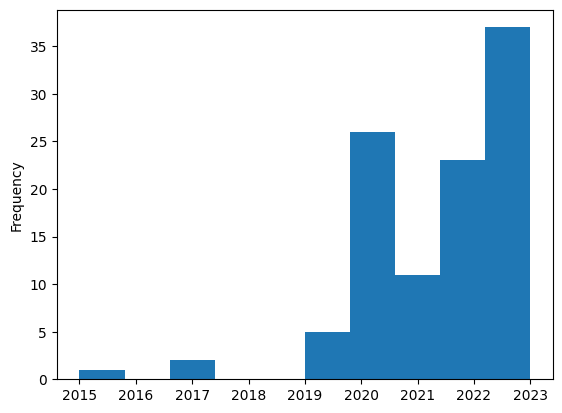

In [214]:
pd.to_datetime(isone[isone["queue_status"].isna() & isone["Status"].eq("Active")]["Queue Date"]).dt.year.plot.hist()

#### Compare total capacity for all projects

In [267]:
gs_capacities = isone[isone.in_gs]["Capacity (MW)"]
lbnl_capacities = isone[isone.in_lbnl]["capacity_mw_resource_1"]

print(f"Ratio of total LBNL capacity to total GS capacity {(gs_capacities.sum() - lbnl_capacities.sum()) / lbnl_capacities.sum() * 100}")
print(f"Ratio of total LBNL project to total GS projects {len(lbnl_capacities) / len(gs_capacities)}")

Ratio of total LBNL capacity to total GS capacity 55.009389792941896
Ratio of total LBNL project to total GS projects 0.8224115334207077


Hmmm substatially more capacity in GS.